**Esutdio i analisis de visbilidad para el dataset de cars**
El Objetivo del TFM es presentar una herramienta que perimta dibujar un coche, es decir pasamos de un dibujo a mano a un coche real, para ello usaremos redes GAN y de visión por comutación.
Imagen input:
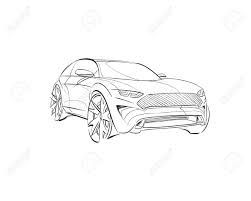

Imagen Output esperada como resultador
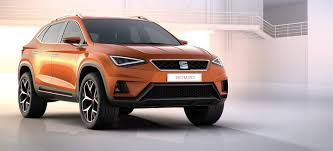


El DataSet que tenemos para trabajar es obtenido de la competicion kaggle CarVana Image Masking Challange
En la competición se solicita hacer un image mask segementation de imagenes de coches reales a la mascara completa del coche. (El objetivo de esta competición no entra en el scope de este TFM).

En este NOTEBOOK usaremos las imagenes de los coches para obetener el contorno y simular un coche dibujado a mano, que usaremos en los siguientes notebook para entrenar nuestras GAN's


Fuentes de información
* Open CV (Canny Edge detection, GaussianBlur, Kernel)-->https://opencv-python-tutroals.readthedocs.io/en/latest/
* Stack Overflow (multiples recursos)[](http://)


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))

import numpy as np
import pandas as pd
import os
from skimage.transform import resize
from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img
from skimage.io import imread, imshow #, concatenate_images
import PIL 
from PIL import Image
import re

['manualdraw', 'carvana-image-masking-challenge']


Using TensorFlow backend.


In [2]:
!mkdir images
#!ls -l '../input/train'

Preparamos unas cuantas funciones para leer del directorio

In [3]:
def files_names_in_path(path="",extension=".jpg"):
    files = []
    masks = []
    for f in os.listdir(path):
        filename, file_extension = os.path.splitext(f)
        if file_extension == '.gif':
            files.append(filename.replace('_mask','')+".jpg")
            masks.append(filename+"_mask.gif")
            
    return files, masks
car_path = '../input/carvana-image-masking-challenge/train/'
mask_path = '../input/carvana-image-masking-challenge/train_masks/'
input_files,input_masks = files_names_in_path(mask_path)

print(input_files[0:5])


['189a2a32a615_06.jpg', '2ea62c1beee7_05.jpg', '189a2a32a615_14.jpg', 'ef5567efd904_09.jpg', 'c53e374fdd72_14.jpg']


In [ ]:
def load_image_and_normalize_and_resize(file_path="",normalize=True):
    if normalize:
        return (imread(file_path)/255)
    else:
        return (imread(file_path))
    

print(load_image_and_normalize_and_resize(car_path+np.random.choice(input_files,1)[0]))
print(imshow(load_image_and_normalize_and_resize(car_path+np.random.choice(input_files,2)[0])))
print(load_image_and_normalize_and_resize(car_path+np.random.choice(input_files,1)[0]).shape)
HEIGH = load_image_and_normalize_and_resize(car_path+np.random.choice(input_files,1)[0]).shape[0]
WIDTH = load_image_and_normalize_and_resize(car_path+np.random.choice(input_files,1)[0]).shape[1]

In [4]:
mask = pd.read_csv('../input/carvana-image-masking-challenge/train_masks.csv')

In [5]:
len(mask)

5088

In [7]:
# ignore this function not needed finally... reference https://www.kaggle.com/robertkag/rle-to-mask-converter finally not used but i like this function i saved..

import numpy as np # linear algebra
#(1280, 1918, 3)

def rleToMask(rleString,height,width):
    rows, cols = height,width
    rleNumbers = [int(numstring) for numstring in rleString.split(' ')]
    rlePairs = np.array(rleNumbers).reshape(-1,2)
    img = np.zeros(rows*cols,dtype=np.uint8)
    for index,length in rlePairs:
        index -= 1
        img[index:index+length] = 255
    img = img.reshape(cols,rows)
    img = img.T
    return img

In [8]:
#index=3
#temp_mask = rleToMask(mask['rle_mask'][3],WIDTH,HEIGH)
#print(temp_mask.shape)
#rotated_mask = np.rot90(np.rot90(np.rot90(temp_mask)))
#imshow(rotated_mask)


In [9]:
# empezamos a trabajar para obtener la mascara del coche solo nos interesa el coche para mejorar el performanc
# ademas queremos simular los trazos humanos extrayendo los edges del coche (pero solo del coche, el fondo no nos interesa)
import cv2
indx=5000
carimage = car_path+input_files[indx]
maskimage = mask_path+input_files[indx].replace('.jpg','_mask.gif')

print(carimage)
print(maskimage)
img = cv2.imread(carimage)
#mask = cv2.imread(maskimage)
mask=imread(maskimage)
print(mask)

# get first masked value (foreground)
fg = cv2.bitwise_or(img, img, mask=mask)
# get second masked value (background) mask must be inverted
mask = cv2.bitwise_not(mask)
background = np.full(img.shape, 255, dtype=np.uint8)
bk = cv2.bitwise_or(background, background, mask=mask)

# combine foreground+background
final = cv2.bitwise_or(fg, bk)

../input/carvana-image-masking-challenge/train/70b6a79565fe_10.jpg
../input/carvana-image-masking-challenge/train_masks/70b6a79565fe_10_mask.gif
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Bien hay que tener presente el objetivo, el objetivo final es usar la liberia OpenCv, en concreto el alghotirmo de CanyEdge detection, que nos permite resaltar y extraer contornos de una imagen, esta imagen va a suer nuestros inputs en las GAN, es decir seremos capaz de reconstruir un coche solamente conociendo su contorno?
Para ellos i conociendo a priori el Canny Edge detection, va a funcionar mejor si somos capaces de extraer de la imagen completa unicamente los elementos que nos interesan, es decir solo el coche

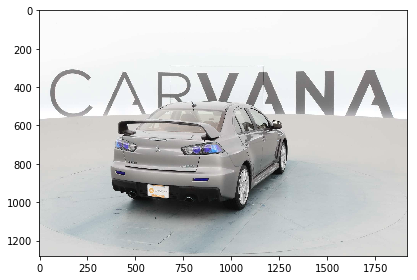

In [13]:
#La imagen original
imshow(img)

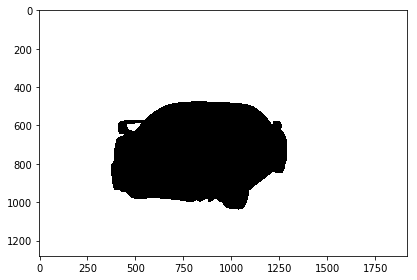

In [17]:
#La mascara
imshow(mask)

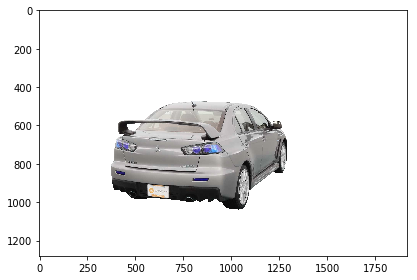

In [18]:
#La imagen del coche aplicando la mascara
# BIEN!!! ahora vamos a intentar extraer los contornos!!
imshow(final)

# Empezamos con un ejemplo basico de la pagina de OpenCV

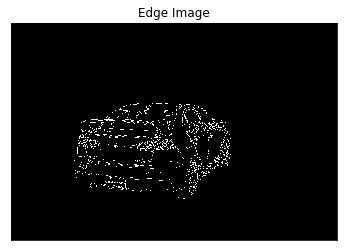

In [19]:

import cv2
import numpy as np
from matplotlib import pyplot as plt

img = final
edges = cv2.Canny(img,50,100)

#plt.subplot(121),
plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
#plt.subplot(122),
plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()
#La aproximación no es muy buena necessitamos las lineas del contorno

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


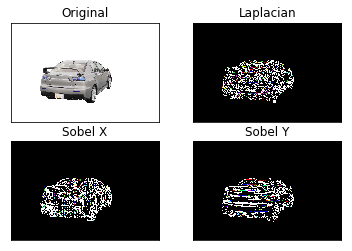

In [20]:
# Usamos otro ejemplo de la pagina OpenCV
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = final

laplacian = cv2.Laplacian(img,cv2.CV_64F)
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)

plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

plt.show()

Estabamos por buen camino, antes de applicar el cannyedge detection tal como explica en la doc de OpenCV, antes se debia de corregir las imagenes aplicando GaussianBlur i erode para cerrar gaps
Adjunto fuentes de información
#https://stackoverflow.com/questions/21104664/extract-all-bounding-boxes-using-opencv-python/21108680
#https://stackoverflow.com/questions/13887863/extract-bounding-box-and-save-it-as-an-image
#https://www.kaggle.com/ayalamann/bounding-boxes-using-image-processing
#https://cvisiondemy.com/extract-roi-from-image-with-python-and-opencv/

(1280, 1918)


255

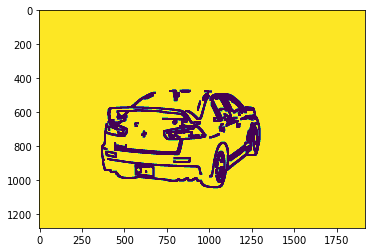

In [24]:
def get_edge_v2(img):
    blurred = cv2.GaussianBlur(img, (7,7), 0) # Remove noise
    #close the small line gaps using errosion
    kernel = np.ones((3,3), np.uint8)
    erode = cv2.erode(blurred, kernel, iterations = 3)
    #plt.imshow(erode)
    #cannyedge 
    def canny_edge_detector(input_img, threshold1, threshold2, draw=True, save=True):
        canny_img = cv2.cvtColor(np.copy(input_img), cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(canny_img, threshold1, threshold2)
        return edges
    #try adding Eroding before edge detection(increase black lines)
    canny_edges = canny_edge_detector(input_img=erode, threshold1=100, threshold2=150) 
    #return np.invert(canny_edges)#return np.invert(canny_edges)
    #plt.imshow(canny_edges)

    #close the small line gaps using dilation
    kernel = np.ones((5,5), np.uint8)
    dilation_canny = cv2.dilate(canny_edges, kernel, iterations = 3)
    canny_blurred = cv2.GaussianBlur(dilation_canny, (3,3), 0) # Remove noise
    #invetimos la mascara queremos el blanco de fondo y el negro como dibujo del coche
    return np.invert(canny_blurred)
ret =get_edge_v2(final)
plt.imshow(ret)
print(ret.shape)
np.max(ret)


Es Fantastico!!! con esto podemos seguir adelante con el TFM!!! Nos preparamos una función get edges random que usaremos en los data augmentation!

In [32]:
def get_edge_v2_randoms(img):
    choise=[3,5,7]
    x = np.random.choice(choise,1)
    
    blurred = cv2.GaussianBlur(img, (x,x), 0) # Remove noise
    #close the small line gaps using errosion
    x = np.random.randint(2,5)
    kernel = np.ones((x,x), np.uint8)
    x = np.random.randint(2,5)
    erode = cv2.erode(blurred, kernel, iterations = x)
    # plt.imshow(erode)
    #cannyedge 
    def canny_edge_detector(input_img, threshold1, threshold2, draw=True, save=True):
        canny_img = cv2.cvtColor(np.copy(input_img), cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(canny_img, threshold1, threshold2)
        return edges
    #try adding Eroding before edge detection(increase black lines)
    x = np.random.randint(80,125)
    y = np.random.randint(135,180)
    canny_edges = canny_edge_detector(input_img=erode, threshold1=100, threshold2=150) 
    #return np.invert(canny_edges)
    # plt.imshow(canny_edges)

    #close the small line gaps using dilation
    x = np.random.randint(2,5)
    kernel = np.ones((x,x), np.uint8)
    x = np.random.randint(2,5)
    dilation_canny = cv2.dilate(canny_edges, kernel, iterations = x)
    
    x = np.random.choice(choise,1)
    canny_blurred = cv2.GaussianBlur(dilation_canny, (x,x), 0) # Remove noise
    return np.invert(canny_blurred)


(1280, 1918)


255

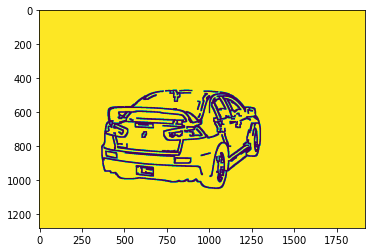

In [33]:
ret =get_edge_v2_randoms(final)
plt.imshow(ret)
print(ret.shape)
np.max(ret)